In [37]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
code = {"GLY" : "G", "ALA" : "A", "LEU" : "L", "ILE" : "I",
        "ARG" : "R", "LYS" : "K", "MET" : "M", "CYS" : "C",
        "TYR" : "Y", "THR" : "T", "PRO" : "P", "SER" : "S",
        "TRP" : "W", "ASP" : "D", "GLU" : "E", "ASN" : "N",
        "GLN" : "Q", "PHE" : "F", "HIS" : "H", "VAL" : "V",
        "M3L" : "K", "MSE" : "M", "CAS" : "C"}
gamma_se_map_1_letter = {   'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
                            'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
                            'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
                            'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}

In [3]:
p=PDBParser()
structure=p.get_structure("x", "/Users/weilu/Research/server/jun_2019/2jo1_simulations/cleaned_pdbs/2jo1.pdb")

In [4]:
res_list = list(structure.get_residues())


In [25]:
x_sum = 0
y_sum = 0
n = len(res_list)
for res in res_list:
    for res2 in res_list:
        res_ca = res["CA"]
        x = res_ca.get_coord()[0]
        y = res_ca.get_coord()[1]
        res2_ca = res2["CA"]
        x2 = res2_ca.get_coord()[0]
        y2 = res2_ca.get_coord()[1]
        rcm_square += x*x2 + y*y2
rcm_square /= n*n
rcm_square

12.654166795607367

In [26]:
x_sum = 0
y_sum = 0
n = len(res_list)
for res in res_list:
    res_ca = res["CA"]
    x = res_ca.get_coord()[0]
    y = res_ca.get_coord()[1]
    x_sum += x
    y_sum += y
rcm_square = (x_sum/n)**2 + (y_sum/n)**2
rcm_square

12.652208986624391

In [22]:
(10.150346128905303 -10.148388124334375) /10.150346128905303

0.00019290027611499965

In [30]:
input_pdb_filename = "/Users/weilu/Research/server/jun_2019/relative_k/database/dompdb/5j4i"

structure = parse_pdb(input_pdb_filename)
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)

In [33]:
pwd

'/Users/weilu/opt/notebook/Optimization'

In [34]:
os.chdir("/Users/weilu/Research/server/jun_2019/relative_k/optimization")

In [39]:
phi_relative_k_well(res_list, neighbor_list, parameter_list="", z_m_high=30)

[659.5255716609299, 31.527819108921417]

In [188]:
input_pdb_filename = "/Users/weilu/Research//server_backup/jan_2019/compute_energy/12asA00"

structure = parse_pdb(input_pdb_filename)
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)
    
cb_density = calculate_cb_density(res_list, neighbor_list)
r_min = 6.5
r_max = 9.5
kappa = 5.0
min_seq_sep = 10
density_threshold = 2.6
density_kappa = 7.0
# phi_mediated_contact_well = np.zeros((2, 20,20))
v_mediated = 0
for res1globalindex, res1 in enumerate(res_list):
    res1index = get_local_index(res1)
    res1chain = get_chain(res1)
    rho_i = cb_density[res1globalindex]
    for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
        res2index = get_local_index(res2)
        res2chain = get_chain(res2)
        res2globalindex = get_global_index(res_list, res2)
        rho_j = cb_density[res2globalindex]
        if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
            res1type = get_res_type(res_list, res1)
            res2type = get_res_type(res_list, res2)
            rij = get_interaction_distance(res1, res2)
            _pij_protein = prot_water_switchFunc_sigmaProt(
                rho_i, rho_j, density_threshold, density_kappa) * protein_gamma_ijm[0][res1type][res2type]
            _pij_water = prot_water_switchFunc_sigmaWater(
                rho_i, rho_j, density_threshold, density_kappa) * water_gamma_ijm[0][res1type][res2type]
            v_mediated += (_pij_protein + _pij_water) * interaction_well(rij, r_min, r_max, kappa)
v_mediated

124.14367615091811

In [180]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00.pdb"

_all = []
seq = ""
p=PDBParser()
structure=p.get_structure("x", input_pdb_filename)
for model in structure:
    for chain in model:
        for residue in chain:
            seq += code[residue.resname]
            if residue.resname == "GLY":
                x,y,z = residue["CA"].get_coord()
            else:
                x,y,z = residue["CB"].get_coord()
            _all.append([x,y,z])
v_direct = 0
n = len(data)
for i in range(n):
    x, y, z = data[i]
    ai = gamma_se_map_1_letter[seq[i]]
    for j in range(i+10, n):
        xj, yj, zj = data[j]
        aj = gamma_se_map_1_letter[seq[j]]
        r = ((x-xj)**2 + (y-yj)**2 + (z-zj)**2)**0.5
        gamma = gamma_ijm[0][ai][aj]
#         gamma = 1
        v_direct += gamma * interaction_well(r, 4.5, 6.5, 5)
v_direct

8.335430302233311

In [187]:
def read_gamma(gammaFile):
    data = np.loadtxt(gammaFile)
    gamma_direct = data[:210]
    gamma_mediated = data[210:]
    return gamma_direct, gamma_mediated
gamma_direct, gamma_mediated = read_gamma("/Users/weilu/openmmawsem/parameters/gamma.dat")

nwell = 1
gamma_ijm = np.zeros((nwell, 20, 20))
water_gamma_ijm = np.zeros((nwell, 20, 20))
protein_gamma_ijm = np.zeros((nwell, 20, 20))
m = 0
count = 0
for i in range(20):
    for j in range(i, 20):
        gamma_ijm[m][i][j] = gamma_direct[count][0]
        gamma_ijm[m][j][i] = gamma_direct[count][0]
        count += 1
count = 0
for i in range(20):
    for j in range(i, 20):
        water_gamma_ijm[m][i][j] = gamma_mediated[count][1]
        water_gamma_ijm[m][j][i] = gamma_mediated[count][1]
        count += 1
count = 0
for i in range(20):
    for j in range(i, 20):
        protein_gamma_ijm[m][i][j] = gamma_mediated[count][0]
        protein_gamma_ijm[m][j][i] = gamma_mediated[count][0]
        count += 1


In [77]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00.pdb"

In [113]:
from Bio.PDB.PDBParser import PDBParser
_all = []
seq = ""
p=PDBParser()
structure=p.get_structure("x", input_pdb_filename)
for model in structure:
    for chain in model:
        for residue in chain:
            seq += code[residue.resname]
            if residue.resname == "GLY":
                x,y,z = residue["CA"].get_coord()
            else:
                x,y,z = residue["CB"].get_coord()
            _all.append([x,y,z])

In [114]:
data = np.array(_all)

In [115]:
data.shape

(327, 3)

In [116]:
len(seq)

327

In [ ]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00"
def compute_mediated(input_pdb_filename):
    structure = parse_pdb(input_pdb_filename)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    cb_density = calculate_cb_density(res_list, neighbor_list)
    r_min = 6.5
    r_max = 9.5
    kappa = 5.0
    min_seq_sep = 10
    density_threshold = 2.6
    density_kappa = 7.0
    # phi_mediated_contact_well = np.zeros((2, 20,20))
    v_mediated = 0
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        rho_i = cb_density[res1globalindex]
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            rho_j = cb_density[res2globalindex]
            if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_interaction_distance(res1, res2)
                _pij_protein = prot_water_switchFunc_sigmaProt(
                    rho_i, rho_j, density_threshold, density_kappa) * protein_gamma_ijm[0][res1type][res2type]
                _pij_water = prot_water_switchFunc_sigmaWater(
                    rho_i, rho_j, density_threshold, density_kappa) * water_gamma_ijm[0][res1type][res2type]
                v_mediated += (_pij_protein + _pij_water) * interaction_well(rij, r_min, r_max, kappa)
    return v_mediated

In [179]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00"
def compute_direct(input_pdb_filename):
    structure = parse_pdb(input_pdb_filename)
    res_list = get_res_list(structure)
    neighbor_list = get_neighbor_list(structure)
    sequence = get_sequence_from_structure(structure)
    r_min = 4.5
    r_max = 6.5
    kappa = 5
    min_seq_sep = 10
    # phi_pairwise_contact_well = np.zeros((20,20))
    v_direct = 0
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_max+2.0):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)
            if res2index - res1index >= min_seq_sep or (res1chain != res2chain and res2globalindex > res1globalindex):
                res1type = get_res_type(res_list, res1)
                res2type = get_res_type(res_list, res2)
                rij = get_interaction_distance(res1, res2)
                gamma = gamma_ijm[0][res1type][res2type]
    #             phi_pairwise_contact_well[res1type][res2type] += interaction_well(rij, r_min, r_max, kappa)
                v_direct += gamma * interaction_well(rij, r_min, r_max, kappa)
    return v_direct

In [158]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/12asA00.pdb"
def compute_direct(input_pdb_filename):
    _all = []
    seq = ""
    p=PDBParser()
    structure=p.get_structure("x", input_pdb_filename)
    for model in structure:
        for chain in model:
            for residue in chain:
                seq += code[residue.resname]
                if residue.resname == "GLY":
                    x,y,z = residue["CA"].get_coord()
                else:
                    x,y,z = residue["CB"].get_coord()
                _all.append([x,y,z])
    v_direct = 0
    n = len(data)
    for i in range(n):
        x, y, z = data[i]
        ai = gamma_se_map_1_letter[seq[i]]
        for j in range(i+10, n):
            xj, yj, zj = data[j]
            aj = gamma_se_map_1_letter[seq[j]]
            r = ((x-xj)**2 + (y-yj)**2 + (z-zj)**2)**0.5
            gamma = gamma_ijm[0][ai][aj]
    #         gamma = 1
            v_direct += gamma * interaction_well(r, 4.5, 6.5, 5)
    #         v_direct += 1
    return v_direct 

In [159]:
compute_direct(input_pdb_filename)

8.33543028505272

In [152]:
v_direct = 0
n = len(data)
for i in range(n):
    x, y, z = data[i]
    ai = gamma_se_map_1_letter[seq[i]]
    for j in range(i+10, n):
        xj, yj, zj = data[j]
        aj = gamma_se_map_1_letter[seq[j]]
        r = ((x-xj)**2 + (y-yj)**2 + (z-zj)**2)**0.5
        gamma = gamma_ijm[0][ai][aj]
        gamma = 1
#         v_direct += gamma * interaction_well(r, 4.5, 6.5, 5)
        v_direct += 1
v_direct 

50403

In [148]:
50403/327

154.13761467889907

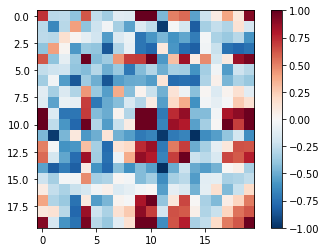

In [141]:
plt.imshow(gamma_ijm[0], cmap="RdBu_r")
plt.colorbar()

In [2]:
def interaction_well_3(r, r_min, r_max, kappa):
    return 0.5 * (np.tanh(kappa * (r + r_min))  + 0.5 * np.tanh(kappa * (r_max - r)))

In [132]:
def interaction_well(r, r_min, r_max, kappa):
    return 0.5 * (np.tanh(kappa * (r - r_min)) * np.tanh(kappa * (r_max - r))) + 0.5

In [153]:
# same as below
def interaction_well(r, r_min, r_max, kappa):
    return 0.25 * (1 + np.tanh(kappa*(r-r_min)))* (1 + np.tanh(kappa*(r_max-r)))

In [18]:
def interaction_well_3(r, r_min, r_max, kappa):
    return 0.5*np.tanh(kappa*(r + r_min))+0.5*np.tanh(kappa*(r_max - r))

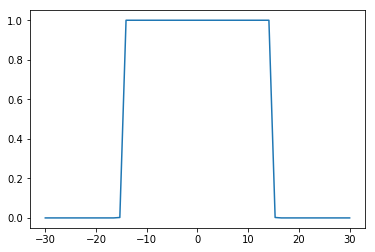

In [19]:
z = np.linspace(-30, 30)
y = interaction_well_3(z, 15, 15, 10)
plt.plot(z,y)

In [22]:
plt.rcParams['figure.facecolor'] = 'w'

In [ ]:
rcParams['figure.facecolor'] = 'w'

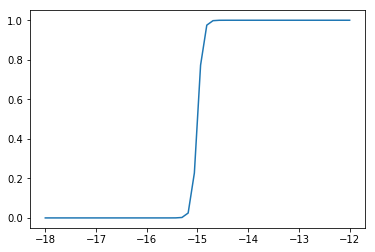

In [23]:
z = np.linspace(-18, -12)
y = interaction_well_3(z, 15, 15, 10)
plt.plot(z,y)

In [16]:
z = np.linspace(-3, 6)
k_m = 2
z_m = 1.5
y = (0.5*np.tanh(k_m*((z-membrane_center)+z_m))+0.5*np.tanh(k_m*(z_m-(z-membrane_center))))

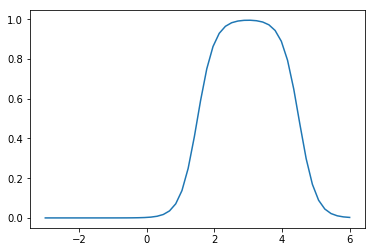

In [17]:
plt.plot(z, y)

In [74]:
def compute_chi(data):
    ca_all = data.query("type == 'CA'")[["x","y","z"]].values
    cb_all = data.query("type == 'CB'")[["x","y","z"]].values
    c_all = data.query("type == 'C'")[["x","y","z"]].values
    n_all = data.query("type == 'N'")[["x","y","z"]].values
    print(len(ca_all), len(cb_all), len(c_all), len(n_all))
    energy = 0 
    for i in range(len(n_all)):
        ca = ca_all[i]
        cb = cb_all[i]
        c = c_all[i]
        n = n_all[i]
        chi0 = -0.83
        k_chi = 20*4.184
        r_ca_cb = cb-ca
        r_c_ca = ca-c
        r_ca_n = n-ca
        norm_r_ca_cb = np.sum(r_ca_cb**2)**0.5
        norm_r_c_ca = np.sum(r_c_ca**2)**0.5
        norm_r_ca_n = np.sum(r_ca_n**2)**0.5
        a = np.cross(-r_c_ca,r_ca_n)/norm_r_c_ca/norm_r_ca_n
        chi = np.dot(a,r_ca_cb)/norm_r_ca_cb
        dchi = chi - chi0
        energy += k_chi*dchi*dchi
    return energy

In [ ]:
input_pdb_filename = "/Users/weilu/Research/server_backup/jan_2019/compute_energy/openmm/12as-openmmawsem.pdb"
data = pd.read_table(input_pdb_filename, sep="\s+", header=None, names=["_","i","type","res","chain","res_id", "x","y","z","_1","_2","_3"])
data = data.dropna().reset_index()
data["res_id"] = data["res_id"].apply(lambda x: int(x))
data["x"] = data["x"].astype(float)

In [76]:
chosen = data.query("res != 'IGL' and res_id != 1 and res_id != 327")
compute_chi(chosen)/4.184

296 296 296 296


84.52557845383485

In [ ]:
def read_beta_parameters():
    ### directly copied from Nick Schafer's
    #os.chdir(parameter_directory)
    in_anti_HB = open("anti_HB", 'r').readlines()
    in_anti_NHB = open("anti_NHB", 'r').readlines()
    in_para_HB = open("para_HB", 'r').readlines()
    in_para_one = open("para_one", 'r').readlines()
    in_anti_one = open("anti_one", 'r').readlines()

    p_par = np.zeros((20))
    p_anti = np.zeros((20))
    p_antihb = np.zeros((20,20,2))
    p_antinhb = np.zeros((20,20,2))
    p_parhb = np.zeros((20,20,2))

    for i in range(20):
        p_par[i] = float(in_para_one[i].strip())
        p_anti[i] = float(in_anti_one[i].strip())
        for j in range(20):
            p_antihb[i][j][0] = float(in_anti_HB[i].strip().split()[j])
            p_antinhb[i][j][0] = float(in_anti_NHB[i].strip().split()[j])
            p_parhb[i][j][0] = float(in_para_HB[i].strip().split()[j])

    for i in range(20):
        for j in range(20):
            p_antihb[i][j][1] = float(in_anti_HB[i+21].strip().split()[j])
            p_antinhb[i][j][1] = float(in_anti_NHB[i+21].strip().split()[j])
            p_parhb[i][j][1] = float(in_para_HB[i+21].strip().split()[j])
    return p_par, p_anti, p_antihb, p_antinhb, p_parhb